<a href="https://colab.research.google.com/github/revanth-reddy/mask-detector-cnn/blob/master/mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [ ]:
train_data = pathlib.Path("Face Mask Dataset/Train")
test_data = pathlib.Path("Face Mask Dataset/Test")
val_data = pathlib.Path("Face Mask Dataset/Validation")

image_count = len(list(train_data.glob('*/*.png')))
print(image_count)

image_count = len(list(test_data.glob('*/*.png')))
print(image_count)

image_count = len(list(val_data.glob('*/*.png')))
print(image_count)



10000
992
800


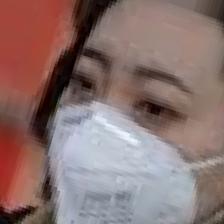

In [ ]:
mask = list(train_data.glob('WithMask/*'))
PIL.Image.open(str(mask[0]))

# with mask image datasetset first image

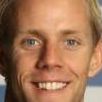

In [ ]:
wmask = list(train_data.glob('WithoutMask/*'))
PIL.Image.open(str(wmask[0]))

# without mask image datasetset first image

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 2 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_data,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 800 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


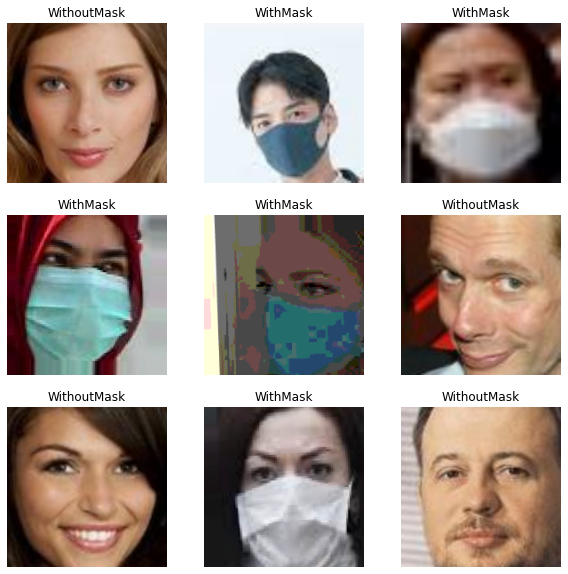

In [ ]:
#First 9 images of dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
'''
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training
'''
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [ ]:
# Model

num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
# Model SUmmary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [ ]:
# Training the Model

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 292s 933ms/step - loss: 0.1168 - accuracy: 0.9524 - val_loss: 0.1563 - val_accuracy: 0.9438
Epoch 2/10
313/313 [==============================] - 291s 930ms/step - loss: 0.0458 - accuracy: 0.9846 - val_loss: 0.0578 - val_accuracy: 0.9812
Epoch 3/10
313/313 [==============================] - 290s 925ms/step - loss: 0.0316 - accuracy: 0.9888 - val_loss: 0.0426 - val_accuracy: 0.9862
Epoch 4/10
313/313 [==============================] - 291s 929ms/step - loss: 0.0264 - accuracy: 0.9907 - val_loss: 0.0527 - val_accuracy: 0.9825
Epoch 5/10
313/313 [==============================] - 289s 922ms/step - loss: 0.0190 - accuracy: 0.9934 - val_loss: 0.0159 - val_accuracy: 0.9937
Epoch 6/10
313/313 [==============================] - 291s 930ms/step - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.0211 - val_accuracy: 0.9950
Epoch 7/10
313/313 [==============================] - 289s 922ms/step - loss: 0.0144 - accuracy: 0.9947 - val_loss: 0.0343 -

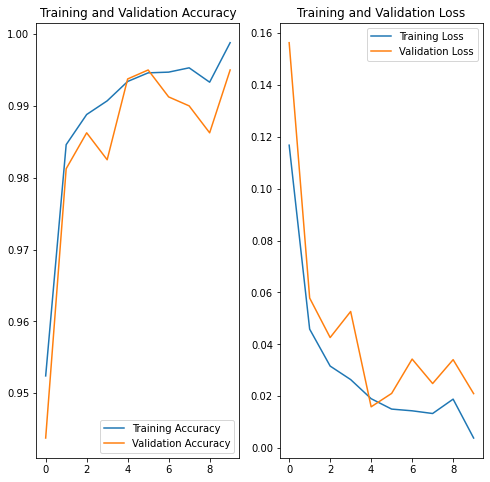

In [ ]:
# Visualizing the Results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

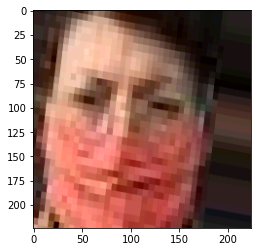

Face Mask Dataset/Test/WithMask/Augmented_99_5504654.png 84.18315649032593


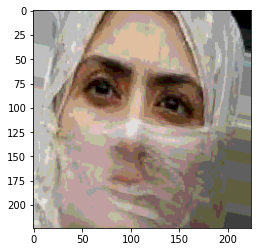

Face Mask Dataset/Test/WithMask/Augmented_353_5799649.png 93.41042041778564


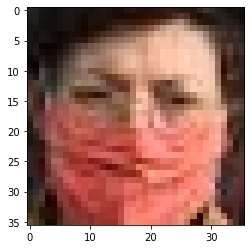

Face Mask Dataset/Test/WithMask/1163.png 85.96945405006409


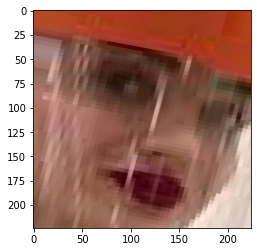

Face Mask Dataset/Test/WithMask/Augmented_689_9677847.png 62.2393012046814


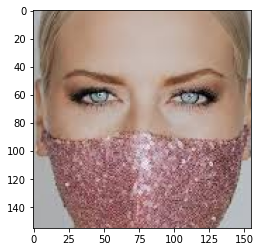

Face Mask Dataset/Test/WithMask/45.png 99.60734844207764


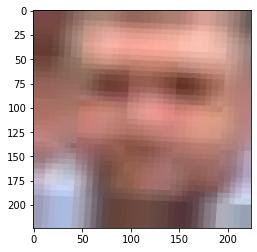

Face Mask Dataset/Test/WithMask/Augmented_890_8528242.png 55.154067277908325


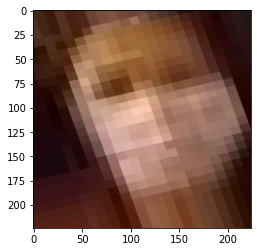

Face Mask Dataset/Test/WithMask/Augmented_187_5733934.png 98.73288869857788


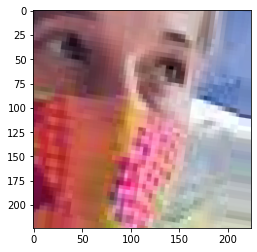

Face Mask Dataset/Test/WithMask/Augmented_30_1910857.png 99.68444108963013
8 / 483


In [ ]:
# Prediction

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


test = list(test_data.glob('WithMask/*'))

count = 0
for test_img in test:
  test_data_path = str(test_img)
  img = keras.preprocessing.image.load_img(
      test_data_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)]!='WithMask':
    count+=1
    img = mpimg.imread(test_data_path)
    imgplot = plt.imshow(img)
    plt.show()
    print(test_data_path, 100 * np.max(score))

print(count,"/",len(test))

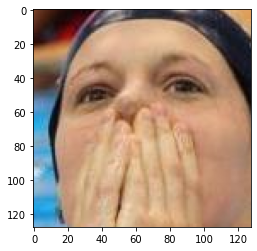

Face Mask Dataset/Test/WithoutMask/5138.png 98.63139390945435


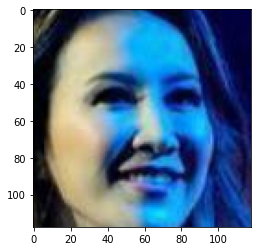

Face Mask Dataset/Test/WithoutMask/3372.png 94.591224193573


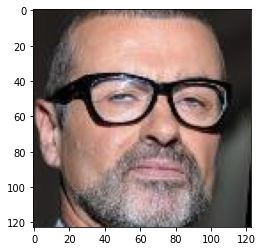

Face Mask Dataset/Test/WithoutMask/51.png 80.50980567932129


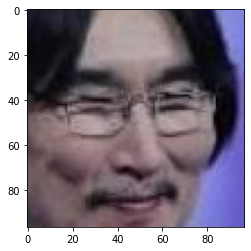

Face Mask Dataset/Test/WithoutMask/3004.png 71.36699557304382


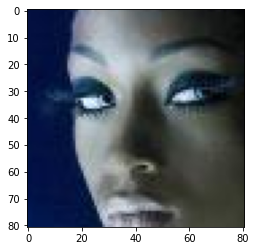

Face Mask Dataset/Test/WithoutMask/1028.png 62.601399421691895
5 / 509


In [ ]:
# Prediction

test = list(test_data.glob('WithoutMask/*'))

count = 0
for test_img in test:
  test_data_path = str(test_img)
  img = keras.preprocessing.image.load_img(
      test_data_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  if class_names[np.argmax(score)]!='WithoutMask':
    count+=1
    img = mpimg.imread(test_data_path)
    imgplot = plt.imshow(img)
    plt.show()
    print(test_data_path, 100 * np.max(score))

print(count,"/",len(test))

In [ ]:
test = list(test_data.glob('WithoutMask/*'))

test_data_path = str(test[0])
img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to WithoutMask with a 100.00 percent confidence.


In [ ]:
# Saving Model

model.save('saved_model/')

INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# Load the saved model and predict

from tensorflow import keras
model = keras.models.load_model('saved_model')


In [ ]:
# test the loaded model

test = list(test_data.glob('WithMask/*'))

test_data_path = str(test[0])
img = keras.preprocessing.image.load_img(
    test_data_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to WithMask with a 100.00 percent confidence.
